In [2]:
import pandas as pd
import numpy as np
from pandas import read_csv
import warnings
warnings.filterwarnings('ignore')
import os 
import  matplotlib.pyplot as plt

In [3]:
# Load dataset
from ucimlrepo import fetch_ucirepo 
bank_marketing = fetch_ucirepo(id=222)  # UCI Bank Marketing

X = pd.DataFrame(bank_marketing.data.features)
y = pd.Series(bank_marketing.data.targets['y'])  # Target column is 'y'





In [4]:
y.info()

<class 'pandas.core.series.Series'>
RangeIndex: 45211 entries, 0 to 45210
Series name: y
Non-Null Count  Dtype 
--------------  ----- 
45211 non-null  object
dtypes: object(1)
memory usage: 353.3+ KB


Feature column of balance and duration shows large standard deviation 

In [5]:
X.describe()

,age,balance,day_of_week,duration,campaign,pdays,previous
count,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000
mean,40.936210,1362.272058,15.806419,258.163080,2.763841,40.197828,0.580323
std,10.618762,3044.765829,8.322476,257.527812,3.098021,100.128746,2.303441
min,18.000000,-8019.000000,1.000000,0.000000,1.000000,-1.000000,0.000000
25%,33.000000,72.000000,8.000000,103.000000,1.000000,-1.000000,0.000000
50%,39.000000,448.000000,16.000000,180.000000,2.000000,-1.000000,0.000000
75%,48.000000,1428.000000,21.000000,319.000000,3.000000,-1.000000,0.000000
max,95.000000,102127.000000,31.000000,4918.000000,63.000000,871.000000,275.000000


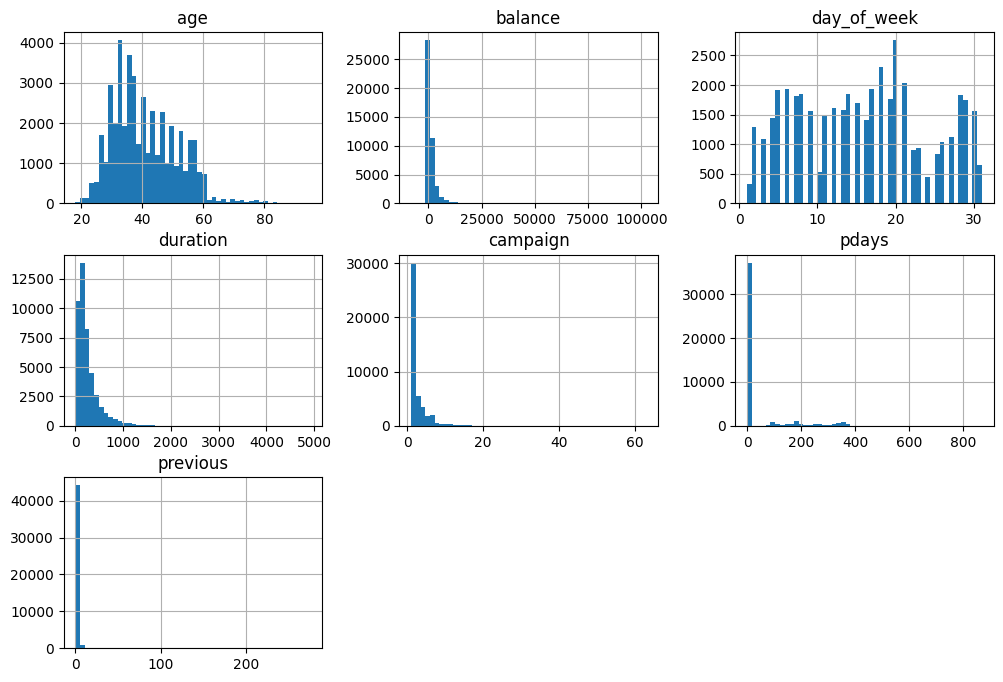

In [6]:
X.hist(bins=50, figsize=(12, 8))
plt.show()

looking at the histogram, It has been noticed that balance data is higly screwed with long tail which shows that mostly customers have low balance, only few have very high balance. This is label oddly shows that the days of month, not days of week. 
Duration: Duration data is highly screwed. Most of the calls are  short (under 1000 second) but some of them are very long, duration is highly predictive in this dataset. 
Compaign: most customers were contacted 1-5 times. A few were contacted excessively. 
Pdays: Days since client was contacted, only one value 275 (which I considered as never contacted)
previous: Number of contacts for this client before current campaign 

Apply log transformation for the heavily tailed distrubuted features. log transformation could only be apply on the positive values as the natural logarithm is not defined for values less than or equal to zero. Therefoer only I applied it on compaign. 

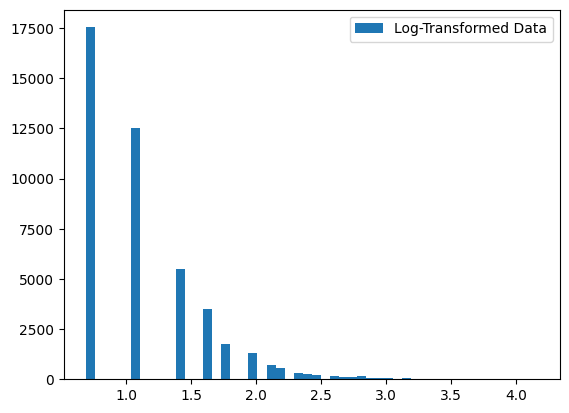

In [7]:
from sklearn.preprocessing import FunctionTransformer
log_transformer = FunctionTransformer(np.log1p)
cols_to_log = ['campaign']
log_data = log_transformer.transform(X[cols_to_log])
plt.hist(log_data, bins=50, label='Log-Transformed Data')
log_df = pd.DataFrame(log_data, columns=cols_to_log, index=X.index)
X[cols_to_log] = log_df
plt.legend()
plt.show()

In [8]:
#how to change the balance skewed data as it has negative values and cannot apply the natural log
X['signed_log_balance'] = np.sign(X['balance']) * np.log1p(np.abs(X['balance']))


In [9]:
print(X[['balance', 'signed_log_balance']].head())
X['balance'] = X['signed_log_balance']
X.drop(columns='signed_log_balance', inplace=True)


   balance  signed_log_balance
0     2143            7.670429
1       29            3.401197
2        2            1.098612
3     1506            7.317876
4        1            0.693147


In [10]:
X.columns

Index(['age', 'job', 'marital', 'education', 'default', 'balance', 'housing',
       'loan', 'contact', 'day_of_week', 'month', 'duration', 'campaign',
       'pdays', 'previous', 'poutcome'],
      dtype='object')

In [11]:
X.rename(columns={'day_of_week': 'day_of_month'}, inplace=True)

In [12]:
mask = y.notna()

In [13]:
y = y.map({'yes': 1, 'no': 0})

In [14]:
y.info()

<class 'pandas.core.series.Series'>
RangeIndex: 45211 entries, 0 to 45210
Series name: y
Non-Null Count  Dtype
--------------  -----
45211 non-null  int64
dtypes: int64(1)
memory usage: 353.3 KB


There is only 5000 clients with yes

In [15]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify= y, random_state=42)

In [16]:
X['education'].unique()

array(['tertiary', 'secondary', nan, 'primary'], dtype=object)

In [17]:
X['day_of_month'].unique()

array([ 5,  6,  7,  8,  9, 12, 13, 14, 15, 16, 19, 20, 21, 23, 26, 27, 28,
       29, 30,  2,  3,  4, 11, 17, 18, 24, 25,  1, 10, 22, 31])

In [18]:
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer

In [19]:
# %% Define feature types
ordinal_cols = ['education']
ordinal_order = [['Unknown', 'primary', 'secondary', 'tertiary']]  # Match dataset values

onehot_cols = ['job', 'marital', 'contact', 'month', 
               'default', 'housing', 'loan']

numeric_cols = ['age', 'balance', 'day_of_month','campaign', 'pdays', 'previous']

# %% Define pipelines
ordinal_pipe = Pipeline([
    ("imputer", SimpleImputer(strategy="constant", fill_value="Unknown")),
    ("encoder", OrdinalEncoder(categories=ordinal_order))
])

onehot_pipe = Pipeline([
    ("imputer", SimpleImputer(strategy="constant", fill_value="missing")),
    ("encoder", OneHotEncoder(handle_unknown="ignore"))
])

numeric_pipe = Pipeline([
    ("imputer", SimpleImputer(strategy="mean")),
    ("scaler", StandardScaler())
])



# %% Combine all preprocessing
preprocessor = ColumnTransformer([
    ("ord", ordinal_pipe, ordinal_cols),
    ("cat", onehot_pipe, onehot_cols),
    ("num", numeric_pipe, numeric_cols)
])



Data Mining models
recall is more important in this case as missing the client is expernsive than contacting someone uninterested.


Model  Logistic Regression
Confusion matrix is:
 [[22552  9385]
 [ 1432  2799]]
precision score is:  0.22972751149047932
recall score is:  0.6615457338690617
F1 score: 0.3410295461468169
Accuracies of 3-fold cross validation are:  [0.69782681 0.70155939 0.70338421]
Model  SVC
Confusion matrix is:
 [[27092  4845]
 [ 1708  2523]]
precision score is:  0.34242671009771986
recall score is:  0.5963129283857244
F1 score: 0.4350375032330373
Accuracies of 3-fold cross validation are:  [0.81685468 0.81345388 0.82614466]
Model  Random Forest
Confusion matrix is:
 [[31419   518]
 [ 3602   629]]
precision score is:  0.5483870967741935
recall score is:  0.14866461829354763
F1 score: 0.23391595388620304
Accuracies of 3-fold cross validation are:  [0.88661248 0.88619774 0.88545123]
Model  Stochastic GD
Confusion matrix is:
 [[31535   402]
 [ 3827   404]]
precision score is:  0.5012406947890818
recall score is:  0.09548570077995745
F1 score: 0.1604129442128251
Accuracies of 3-fold cross validation are:

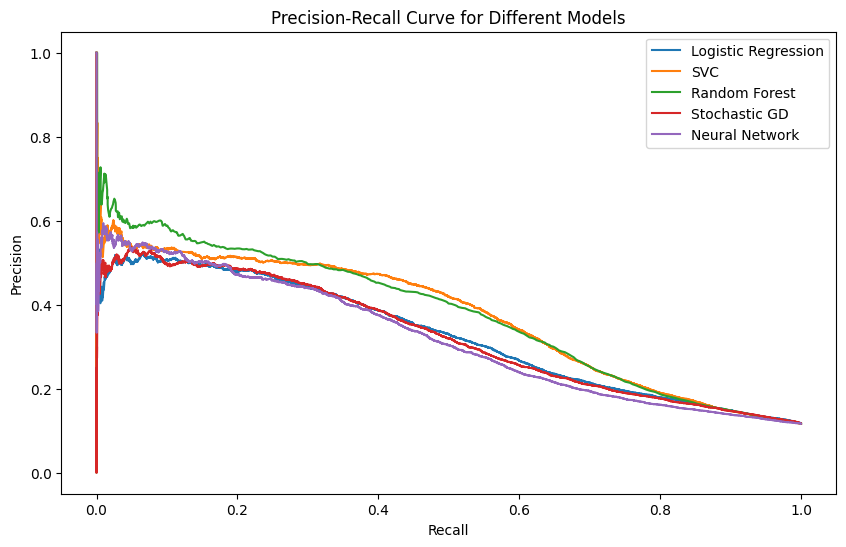

In [20]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import SGDClassifier
from sklearn.pipeline import make_pipeline
from sklearn.svm import LinearSVC
from sklearn.calibration import CalibratedClassifierCV
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import f1_score
from sklearn.model_selection import cross_val_predict, cross_val_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score, recall_score
from sklearn.metrics import precision_recall_curve
# Add Neural Network and Linear SVM to models
models = {
    "Logistic Regression": LogisticRegression(random_state=42, class_weight='balanced'),
    "SVC": SVC(probability=True, random_state=42, class_weight='balanced'),
    "Random Forest": RandomForestClassifier(n_estimators=500, random_state=42, class_weight='balanced'),
    "Stochastic GD": SGDClassifier(loss="log_loss", max_iter=1000, tol=1e-5, eta0=0.01,
                                   n_iter_no_change=10, random_state=42),
    "Neural Network": MLPClassifier(hidden_layer_sizes=(100,), max_iter=500, random_state=42),

}


# Ploting PR Curve
fig, ax = plt.subplots(figsize=(10, 6))

# Train and evaluate models on training set
for name, model in models.items():
    clf = make_pipeline(preprocessor, model)
    #clf.fit(X_train, y_train)
    y_train_pred = cross_val_predict(clf, X_train, y_train, cv=3)
        
    print("Model ", name)
    print("Confusion matrix is:\n", confusion_matrix(y_train, y_train_pred))
    print("precision score is: ", precision_score(y_train, y_train_pred))
    print("recall score is: ", recall_score(y_train, y_train_pred))
    print("F1 score:", f1_score(y_train, y_train_pred)) 
    print("Accuracies of 3-fold cross validation are: ", cross_val_score(clf, X_train, y_train, cv=3, scoring="accuracy"))  
    
    if name == "LinearSVC":
        calibrated_svm = CalibratedClassifierCV(clf, cv=3)
        calibrated_svm.fit(X_train, y_train)
        y_probas_clf = calibrated_svm.predict_proba(X_train)  
    else:
        y_probas_clf = cross_val_predict(clf, X_train, y_train, cv=3, method="predict_proba")
        
    y_scores_clf = y_probas_clf[:, 1]
    precisions, recalls, _ = precision_recall_curve(y_train, y_scores_clf)
    ax.plot(recalls, precisions, label=name)


# But note: LinearSVC also does NOT support predict_proba()
# You could use CalibratedClassifierCV to get probabilities:
# svm_clf = make_pipeline(preprocessing, LinearSVC(random_state=42))

# calibrated_svm = CalibratedClassifierCV(svm_clf, cv=3)
# calibrated_svm.fit(X_train, y_train)
# y_probas_clf = calibrated_svm.predict_proba(X_train)  # or test set

# y_scores_clf = y_probas_clf[:, 1]
# precisions, recalls, _ = precision_recall_curve(y_train, y_scores_clf)
# ax.plot(recalls, precisions, label="LinearSVC")


# Labels and legend
ax.set_xlabel('Recall')
ax.set_ylabel('Precision')
ax.set_title('Precision-Recall Curve for Different Models')
ax.legend(loc='best')
plt.show()

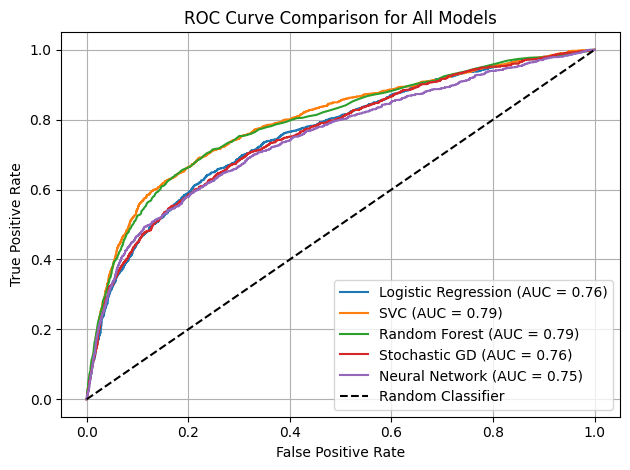

In [21]:

from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve, auc

for name, model in models.items():
    # Combine preprocessing and model
    clf = Pipeline([
        ("preprocessing", preprocessor),
        ("classifier", model)
    ])

    # Fit the model
    clf.fit(X_train, y_train)

    # Get predicted probabilities or decision function
    if hasattr(clf.named_steps["classifier"], "predict_proba"):
        y_probs = clf.predict_proba(X_test)[:, 1]
    else:
        # Use decision function and normalize if no predict_proba
        y_scores = clf.decision_function(X_test)
        y_probs = (y_scores - y_scores.min()) / (y_scores.max() - y_scores.min())

    # Compute ROC curve and AUC
    fpr, tpr, _ = roc_curve(y_test, y_probs)
    roc_auc = auc(fpr, tpr)

    plt.plot(fpr, tpr, label=f"{name} (AUC = {roc_auc:.2f})")

# --- Final plot settings ---
plt.plot([0, 1], [0, 1], 'k--', label='Random Classifier')
plt.title("ROC Curve Comparison for All Models")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right")
plt.grid(True)
plt.tight_layout()
plt.show()

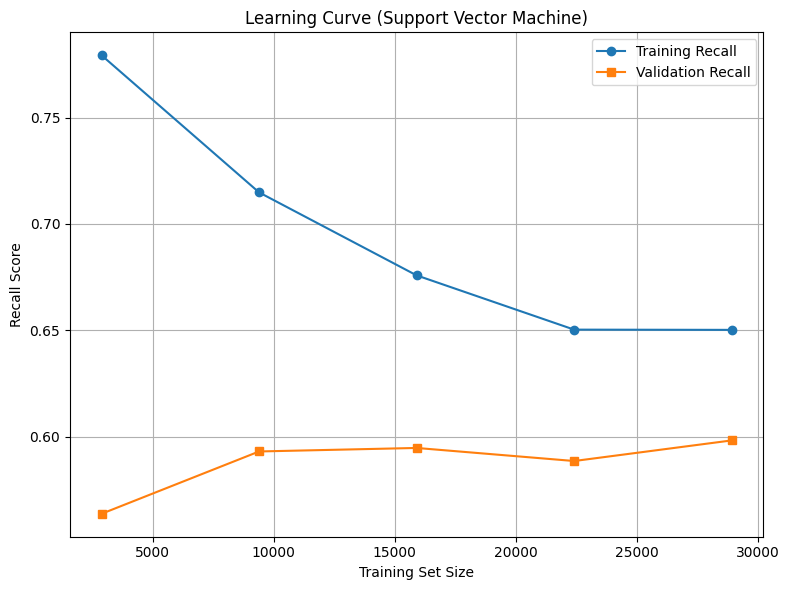

In [22]:
from sklearn.model_selection import learning_curve

# Build a simple pipeline with one classifier (e.g., Logistic Regression)
lr_pipeline = Pipeline([
    ("preprocessor", preprocessor),
    ("classifier", SVC(probability=True, random_state=42, class_weight='balanced'))
])

train_sizes, train_scores, test_scores = learning_curve(
    lr_pipeline,
    X_train,
    y_train,
    cv=5,
    scoring='recall',   # Focus on recall due to class imbalance
    train_sizes=np.linspace(0.1, 1.0, 5),
    n_jobs=-1
)

train_scores_mean = np.mean(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)

# Plot learning curve
plt.figure(figsize=(8, 6))
plt.plot(train_sizes, train_scores_mean, label="Training Recall", marker='o')
plt.plot(train_sizes, test_scores_mean, label="Validation Recall", marker='s')
plt.title("Learning Curve (Support Vector Machine)")
plt.xlabel("Training Set Size")
plt.ylabel("Recall Score")
plt.legend(loc="best")
plt.grid(True)
plt.tight_layout()
plt.show()


/Users/iqra/Desktop/Sharefolder/Master_DataScience/1_MS_DataScience/Portfolio/dev/lib/python3.13/site-packages/sklearn/linear_model/_linear_loss.py:200: RuntimeWarning: divide by zero encountered in matmul
  raw_prediction = X @ weights + intercept
/Users/iqra/Desktop/Sharefolder/Master_DataScience/1_MS_DataScience/Portfolio/dev/lib/python3.13/site-packages/sklearn/linear_model/_linear_loss.py:200: RuntimeWarning: overflow encountered in matmul
  raw_prediction = X @ weights + intercept
/Users/iqra/Desktop/Sharefolder/Master_DataScience/1_MS_DataScience/Portfolio/dev/lib/python3.13/site-packages/sklearn/linear_model/_linear_loss.py:200: RuntimeWarning: invalid value encountered in matmul
  raw_prediction = X @ weights + intercept
/Users/iqra/Desktop/Sharefolder/Master_DataScience/1_MS_DataScience/Portfolio/dev/lib/python3.13/site-packages/sklearn/linear_model/_linear_loss.py:330: RuntimeWarning: divide by zero encountered in matmul
  grad[:n_features] = X.T @ grad_pointwise + l2_reg_st

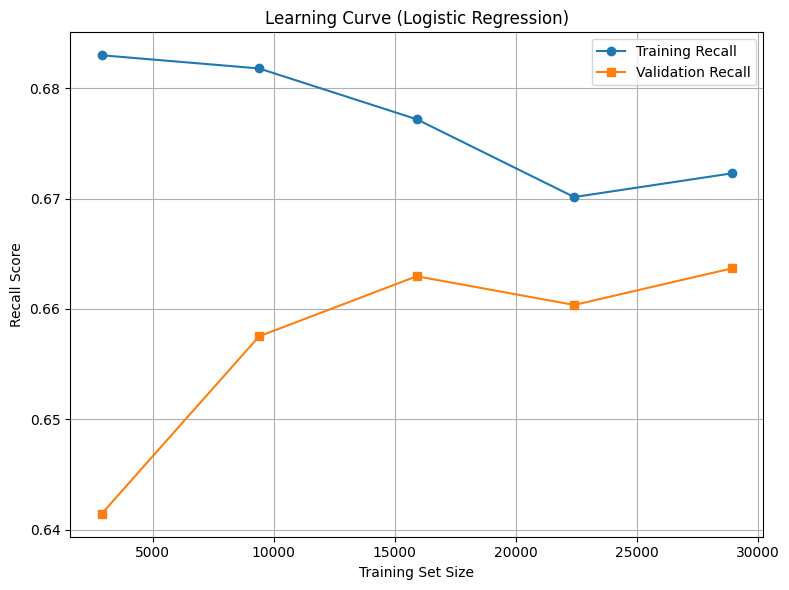

In [23]:
from sklearn.model_selection import learning_curve

# Build a simple pipeline with one classifier (e.g., Logistic Regression)
lr_pipeline = Pipeline([
    ("preprocessor", preprocessor),
    ("classifier", LogisticRegression(random_state=42, class_weight='balanced'))
])

train_sizes, train_scores, test_scores = learning_curve(
    lr_pipeline,
    X_train,
    y_train,
    cv=5,
    scoring='recall',   # Focus on recall due to class imbalance
    train_sizes=np.linspace(0.1, 1.0, 5),
    n_jobs=-1
)

train_scores_mean = np.mean(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)

# Plot learning curve
plt.figure(figsize=(8, 6))
plt.plot(train_sizes, train_scores_mean, label="Training Recall", marker='o')
plt.plot(train_sizes, test_scores_mean, label="Validation Recall", marker='s')
plt.title("Learning Curve (Logistic Regression)")
plt.xlabel("Training Set Size")
plt.ylabel("Recall Score")
plt.legend(loc="best")
plt.grid(True)
plt.tight_layout()
plt.show()


the report shows that only 60% of time yes prediction is true and also recall is low (the model missing 72% of real yes). overall, model fail to capture the minority class. well. The model is good at predicting no and bad in predicting yes which is concerning in this case (market compaign responder).


🔍 Evaluating: Logistic Regression
Avg Recall: 0.665

🔍 Evaluating: SVC
Avg Recall: 0.592

🔍 Evaluating: Random Forest
Avg Recall: 0.154

🔍 Evaluating: Stochastic GD
Avg Recall: 0.081

🔍 Evaluating: Neural Network
Avg Recall: 0.267


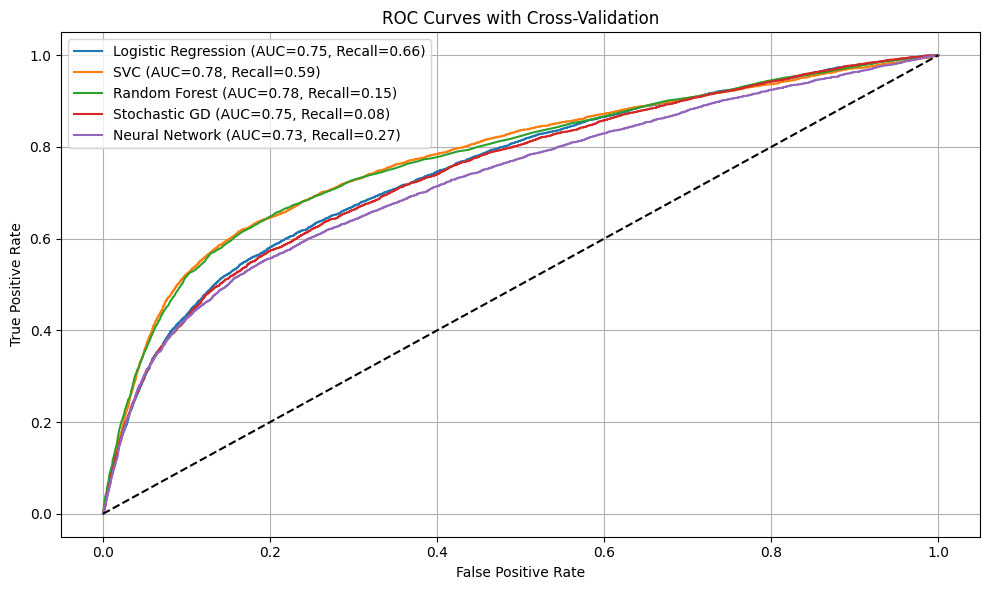

In [24]:
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict, StratifiedKFold
from sklearn.metrics import roc_auc_score, roc_curve, recall_score, make_scorer

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
recall_scorer = make_scorer(recall_score)

plt.figure(figsize=(10, 6))
trained_models = {}

# Evaluate each model
for name, model in models.items():
    print(f"\n🔍 Evaluating: {name}")

    pipeline = Pipeline([
        ("preprocessor", preprocessor),
        ("classifier", model)
    ])

    # Cross-validated recall
    recall_scores = cross_val_score(pipeline, X_train, y_train, cv=cv, scoring=recall_scorer)
    print(f"Avg Recall: {recall_scores.mean():.3f}")

    # Predict probabilities for ROC-AUC
    if hasattr(model, "predict_proba"):
        y_proba = cross_val_predict(pipeline, X_train, y_train, cv=cv, method='predict_proba')[:, 1]
        fpr, tpr, _ = roc_curve(y_train, y_proba)
        auc = roc_auc_score(y_train, y_proba)
        plt.plot(fpr, tpr, label=f"{name} (AUC={auc:.2f}, Recall={recall_scores.mean():.2f})")
    else:
        print(f" {name} does not support predict_proba.")

    pipeline.fit(X_train, y_train)
    trained_models[name] = pipeline

# Plot ROC
plt.plot([0, 1], [0, 1], "k--")
plt.title("ROC Curves with Cross-Validation")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

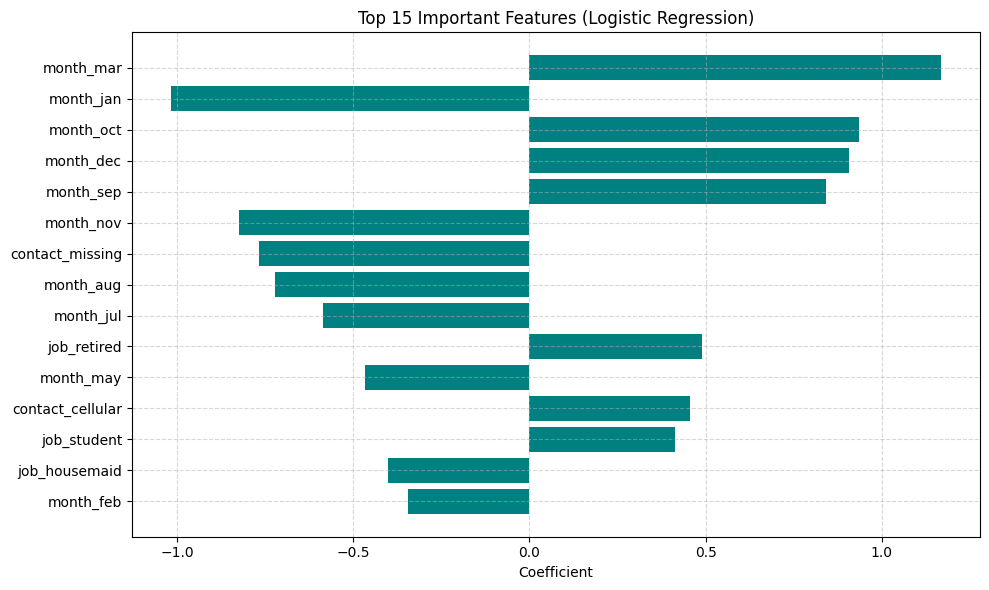

In [25]:
# Fit model
final_pipeline = Pipeline([
    ("preprocessor", preprocessor),
    ("classifier", models["Logistic Regression"])
])
final_pipeline.fit(X_train, y_train)

# Extract features
log_reg = final_pipeline.named_steps["classifier"]
pre = final_pipeline.named_steps["preprocessor"]
feature_names = (
    pre.transformers_[0][2] +  # Ordinal
    list(pre.named_transformers_["cat"].named_steps["encoder"].get_feature_names_out(onehot_cols)) +
    pre.transformers_[2][2]  # Numeric
)

coefs = log_reg.coef_[0]
odds = np.exp(coefs)
feat_imp = pd.DataFrame({
    'Feature': feature_names,
    'Coefficient': coefs,
    'Odds Ratio': odds,
    'Abs(Coefficient)': np.abs(coefs)
}).sort_values(by='Abs(Coefficient)', ascending=False)

# Plot
plt.figure(figsize=(10, 6))
top = feat_imp.head(15)
plt.barh(top['Feature'], top['Coefficient'], color='teal')
plt.xlabel("Coefficient")
plt.title("Top 15 Important Features (Logistic Regression)")
plt.gca().invert_yaxis()
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


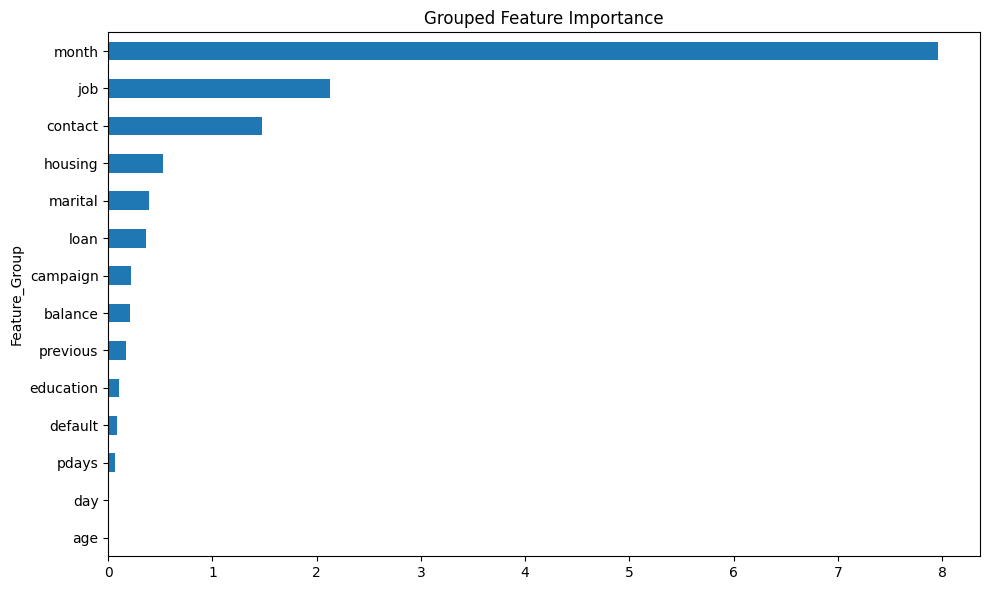

In [26]:
feat_imp["Feature_Group"] = feat_imp["Feature"].str.extract(r"(^[^_]+)")
grouped = (
    feat_imp.groupby("Feature_Group")["Abs(Coefficient)"]
    .sum()
    .sort_values(ascending=False)
)

grouped.plot(kind="barh", figsize=(10, 6), title="Grouped Feature Importance")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()
